In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
IN_FP = '../input/store-sales-time-series-forecasting'
TRAIN_FP = os.path.join(IN_FP, 'train.csv')
TEST_FP = os.path.join(IN_FP, 'test.csv')

In [4]:
store_sales = pd.read_csv(
    TRAIN_FP,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [5]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [6]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']    
)
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ...                                                   \
family      ... MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...  0.074074    5.013166      2.629630     0.074074   
2017-01-02  ...  7.777778  488.522339    714.370361    12.814815   
2017-01-03  ...  3.500000  427.520905    488.333344     8.870370   
2017-01-04  ...  3.500000  369.121490    426.574066     8.129630   
2017-01-05  ...  3.203704  368.945679    360.925934     7.629630   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-01                0.222222    2.855537       1.040722    31.163778   
2017-01-02               22.777779  581.413147     153.555542  3409.500488   
2017-01-03               13.555555  462.013672     125.820534  3394.559814   
2017-01-04               12.092592  431.276398     116.740814  3467.447998   
2017-01-05               10.333333  345.673492     101.434570  2069.316650   

                                                  
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-01                   0.000000   0.259259  
2017-01-02                   2.925926  33.581944  
2017-01-03                   2.018518  27.135260  
2017-01-04                   1.722222  22.034130  
2017-01-05                   1.425926  20.615334  

[5 rows x 33 columns]

In [7]:
test = pd.read_csv(
    TEST_FP,
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [8]:
print("Training Data\n", store_sales, "\n\n")
print("Test Data\n", test)

Training Data
                                      sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns] 


Test Data
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...   

*Note the problem requires a 16 day forecast with 1 step lead time*

### Trend
Extract long term trend with linear regression

<AxesSubplot:title={'center':'Average Sales - 365-Day Moving Average'}, xlabel='date'>

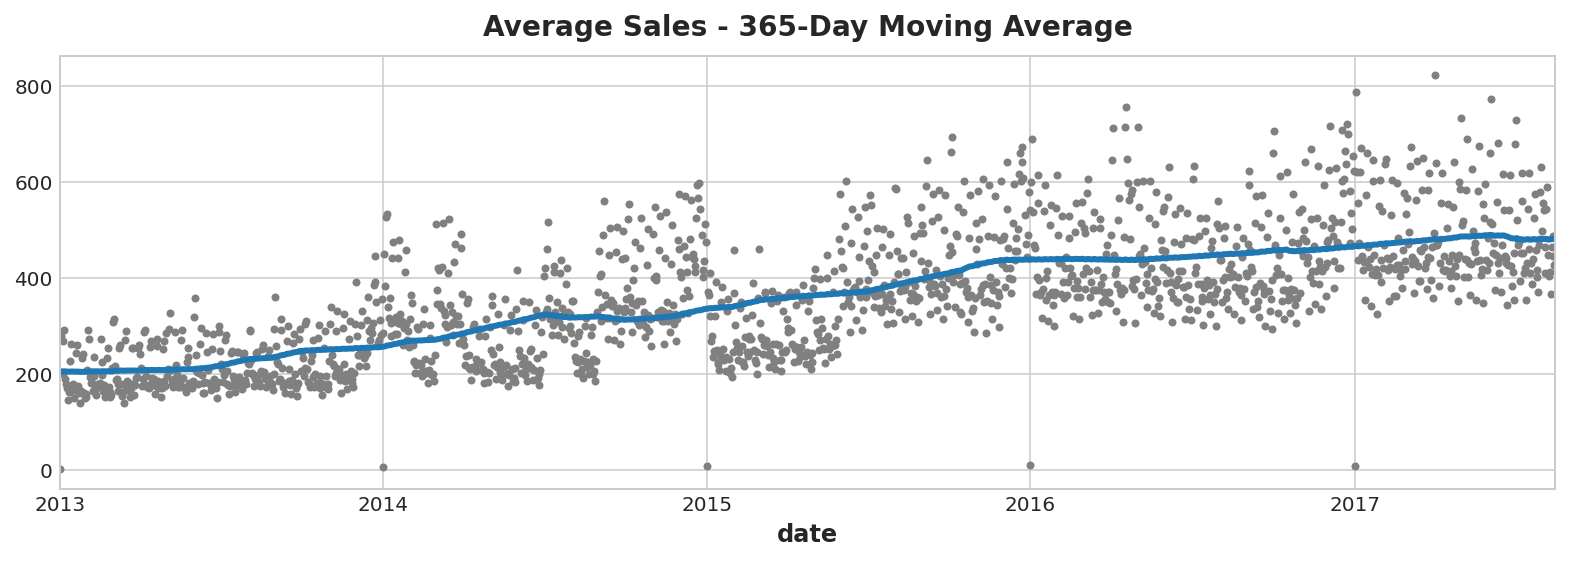

In [9]:
# Moving Average Trend
moving_average = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Average Sales - 365-Day Moving Average")

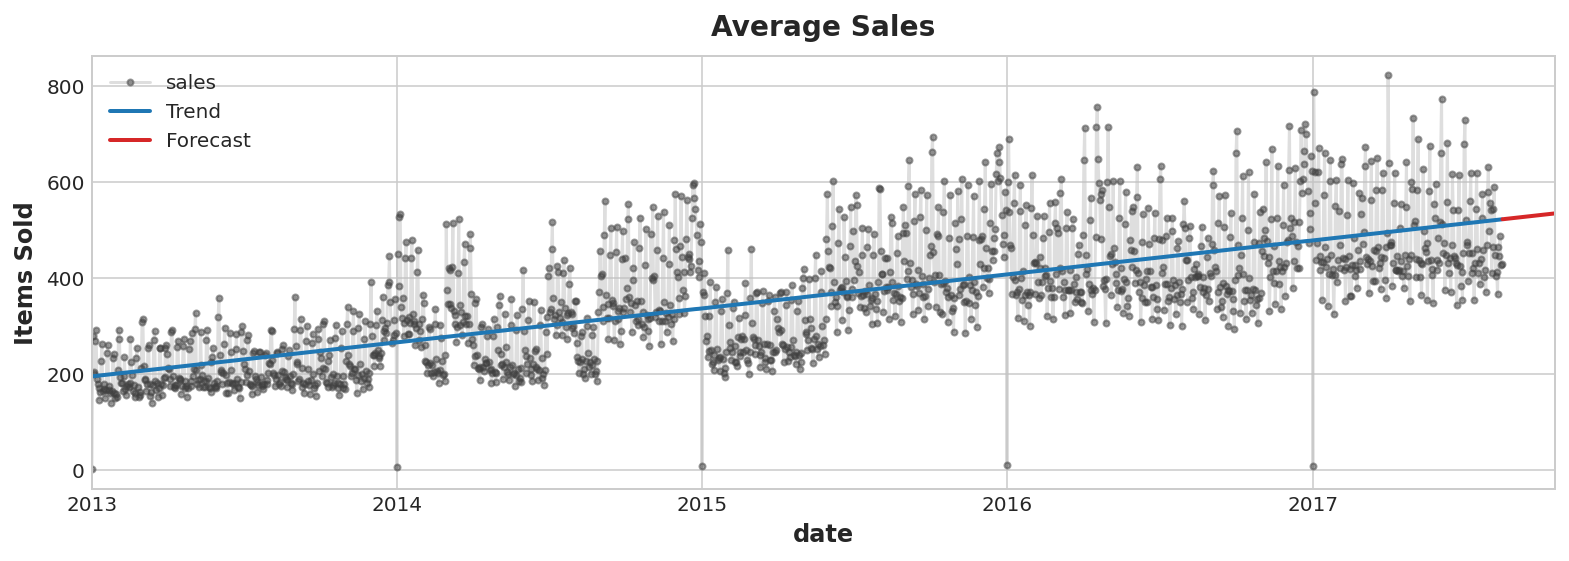

In [10]:
# Average sales polynomial trend and associated forecast

y = average_sales.copy()

dp = DeterministicProcess(
    index=y.index,
    order=1,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="Items Sold")
ax = y_pred.plot(ax=ax, linewidth=2, label="Trend", color="C0")
ax = y_fore.plot(ax=ax, linewidth=2, label="Forecast", color="C3")
ax.legend()

In [11]:
# Fit to individual stores and categories
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [12]:
dp = DeterministicProcess(
    index=y.index,
    order=1,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Text(0.5, 1.0, 'AUTOMOTIVE Sales at Store 50')

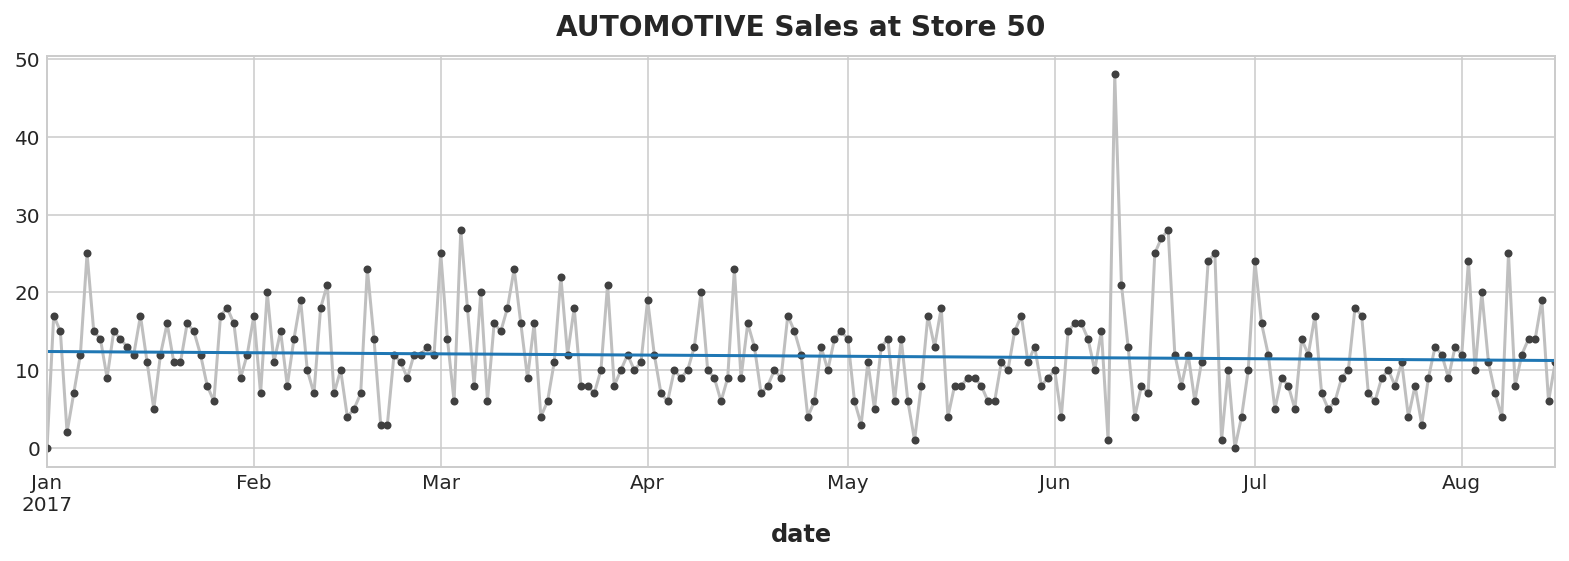

In [13]:
# Check against different store numbers and series
STORE = '50'
FAMILY = 'AUTOMOTIVE'

ax = y.loc(axis=1)['sales', STORE, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE}')

In [14]:
# Seasonal plotting function

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center"        
        )
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

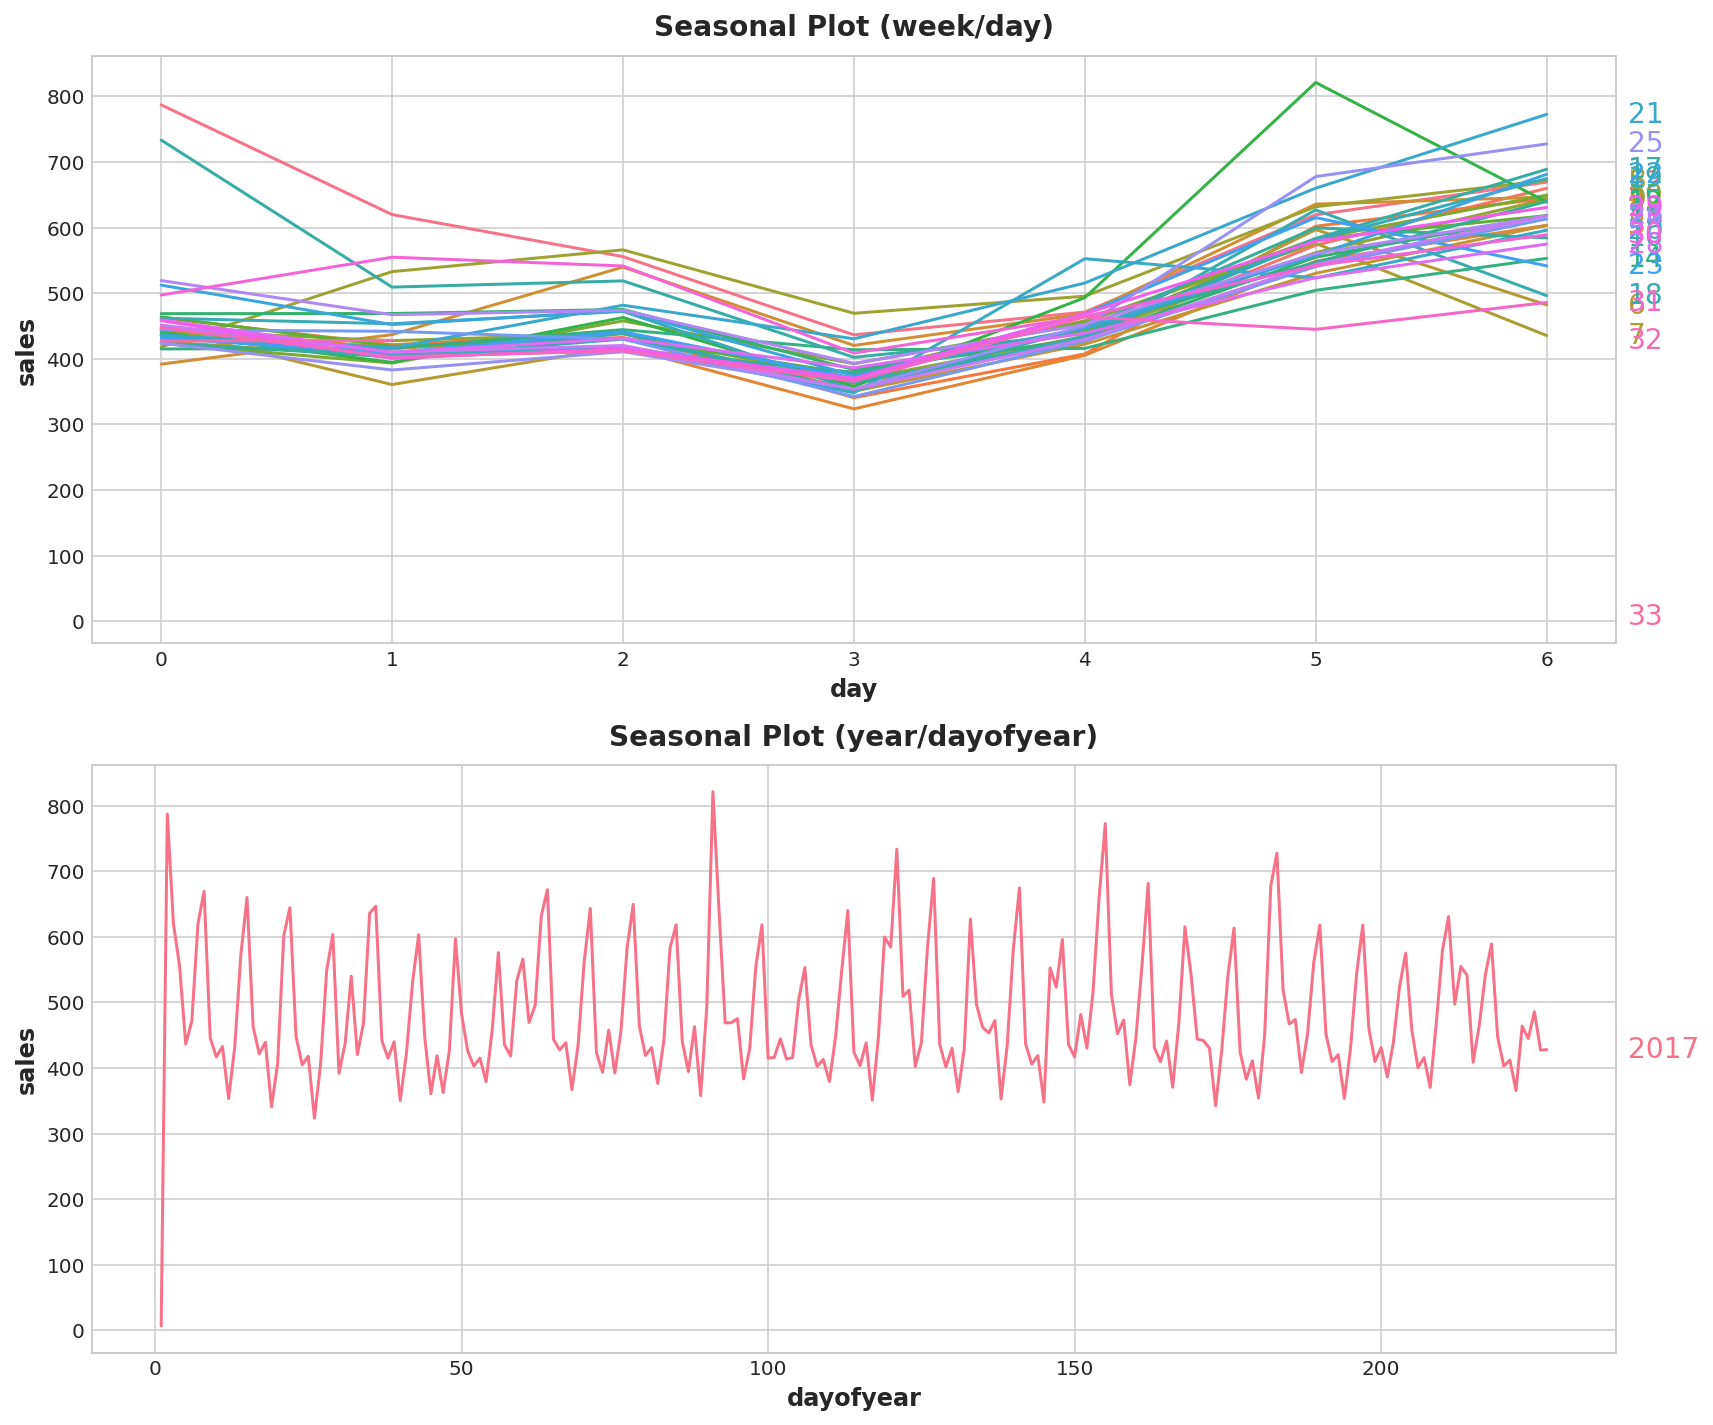

In [15]:
# Seasonal plot by week and year

X = average_sales.to_frame().loc["2017"]

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
seasonal_plot(X, y="sales", period="week", freq="day", ax=axs[0])
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=axs[1])

In [16]:
# Periodogram
def plot_periodogram(ts, detrend="linear", ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum'    
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)"
        ],
        rotation=30
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

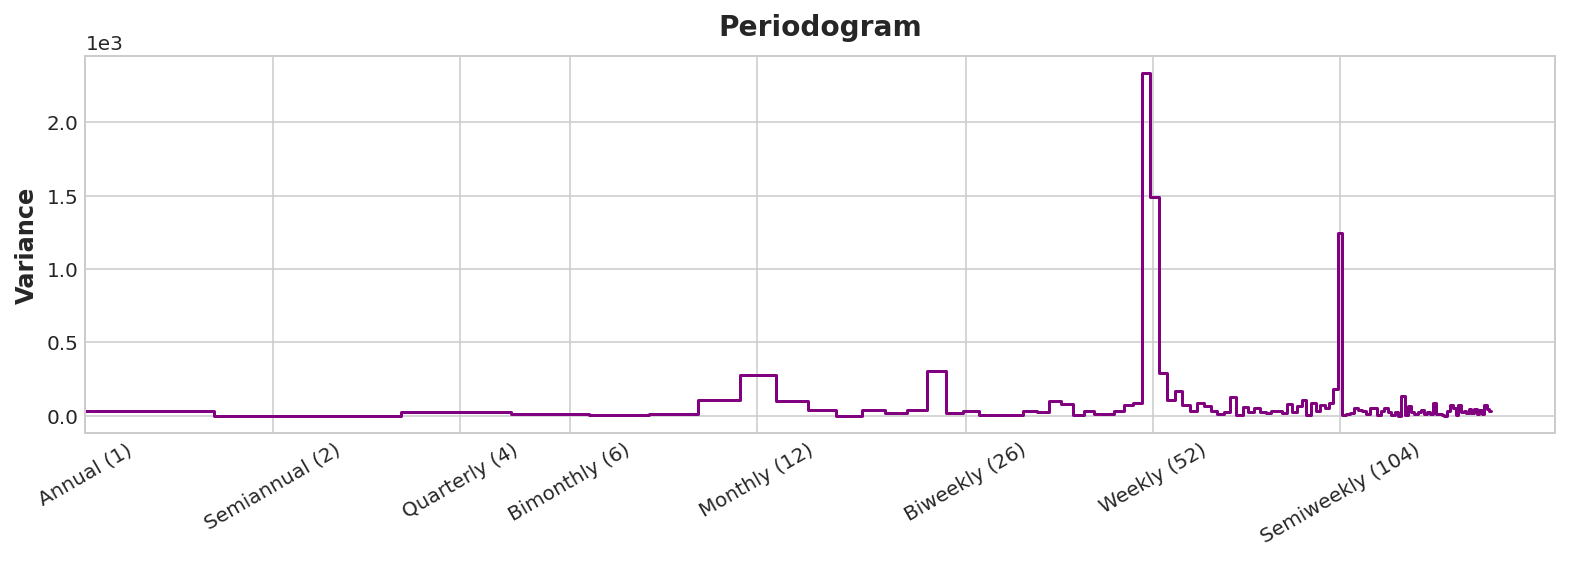

In [17]:
plot_periodogram(average_sales.loc["2017"])

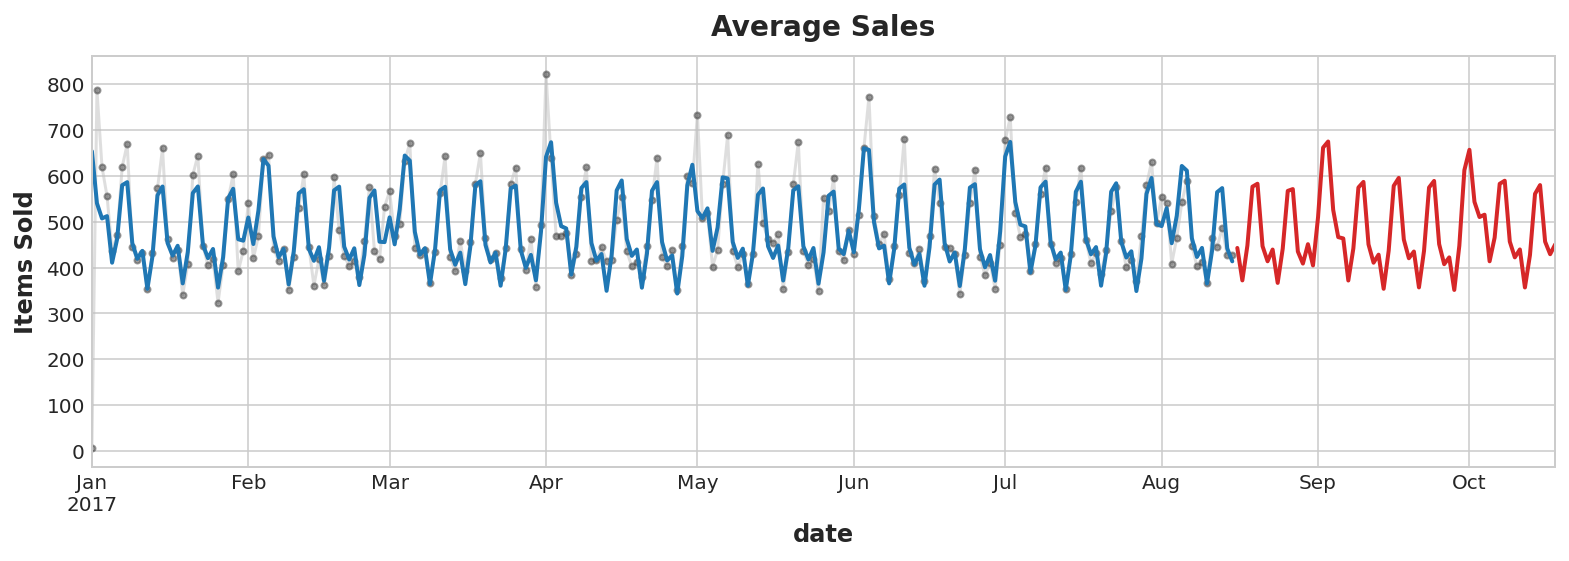

In [18]:
# Monthly and weekly seasonan
y = average_sales['2017'].copy()

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="Items Sold" , alpha=0.5)
ax = y_pred.plot(label="Trend", linewidth=2, color='C0')
ax = y_fore.plot(label="Prediction", linewidth=2, color='C3')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  import sys


<bound method NDFrame.head of date
2017-01-01   -646.895992
2017-01-02    246.665065
2017-01-03    112.620599
2017-01-04     43.382111
2017-01-05     25.715551
                 ...    
2017-08-11     26.696323
2017-08-12   -119.604419
2017-08-13    -87.534263
2017-08-14    -14.760334
2017-08-15     14.360773
Freq: D, Length: 227, dtype: float64>

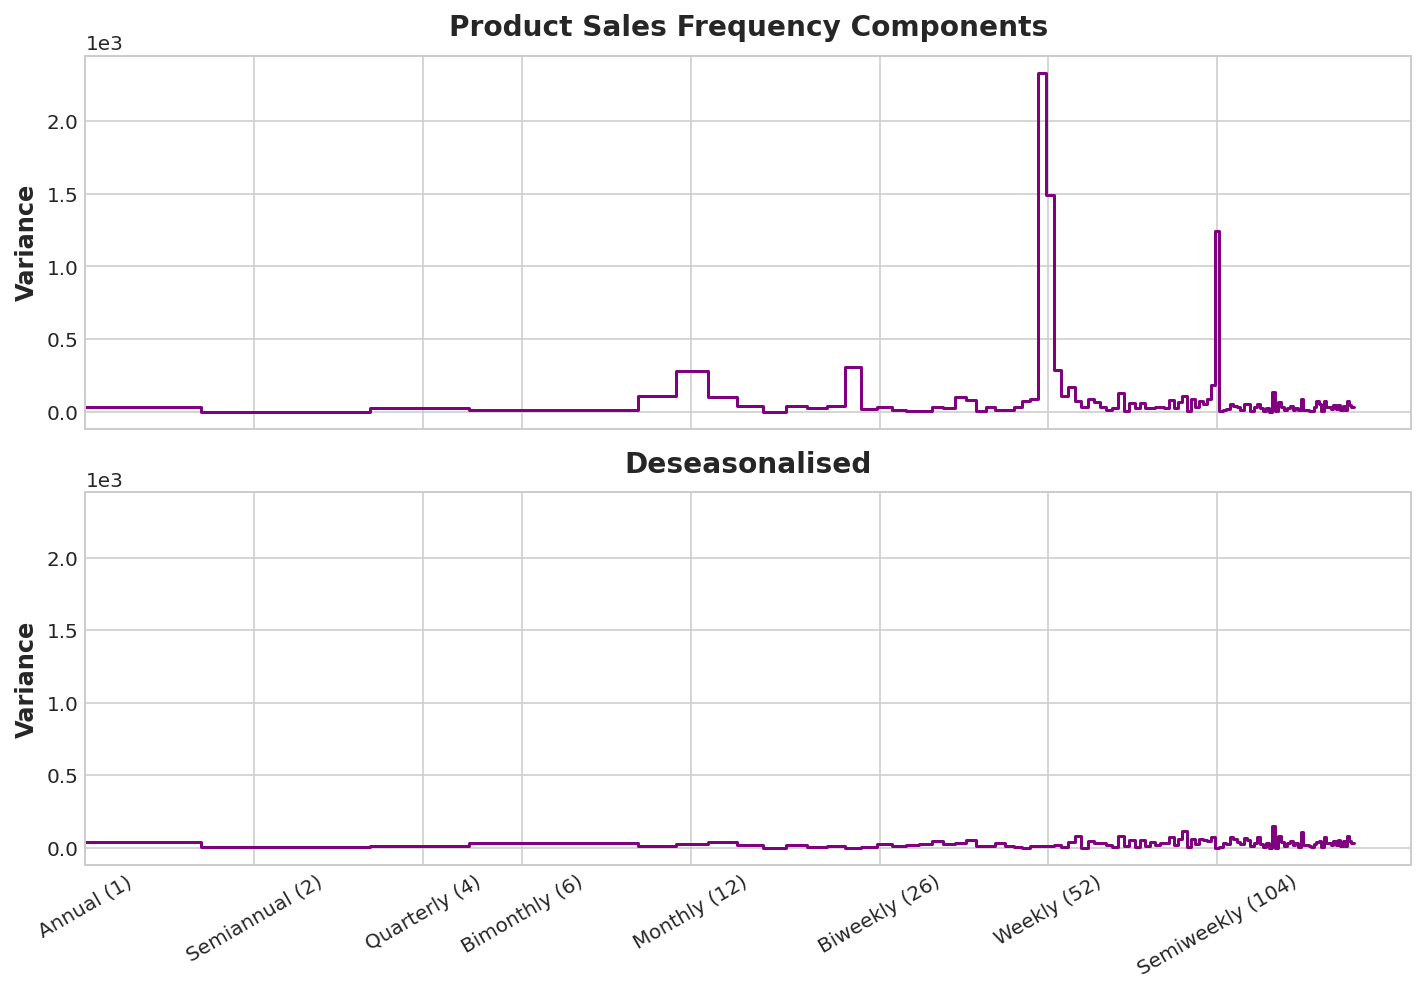

In [19]:
y_deseason = y - y_pred

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 7))

axs[0] = plot_periodogram(y, ax=axs[0])
axs[0].set_title("Product Sales Frequency Components")
axs[1] = plot_periodogram(y_deseason, ax=axs[1])
axs[1].set_title("Deseasonalised")

y_deseason.head

In [20]:
def corrPlot(X, x_param, y_param, dates=None):   
    x_ = X[x_param]
    y_ = X[y_param]
    
    if dates:
        x_ = x_.loc[dates]
        y_ = y_.loc[dates]

    corr = y_.corr(x_)

    scatter_kws = dict(
        alpha=0.75,
        s=5,
    )
    line_kws = dict(color='C3', )


    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws = scatter_kws,
        line_kws=line_kws,
        lowess=True,
        ax=ax
    )

    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

In [30]:
# Additional Data
import datetime
OIL_FP = os.path.join(IN_FP, 'oil.csv')

oil = pd.read_csv(
    OIL_FP,
    parse_dates=['date'],
    infer_datetime_format=True
)

oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil['average_store_sales'] = average_sales

Text(0.5, 1.0, 'Store Sales and Oil Price')

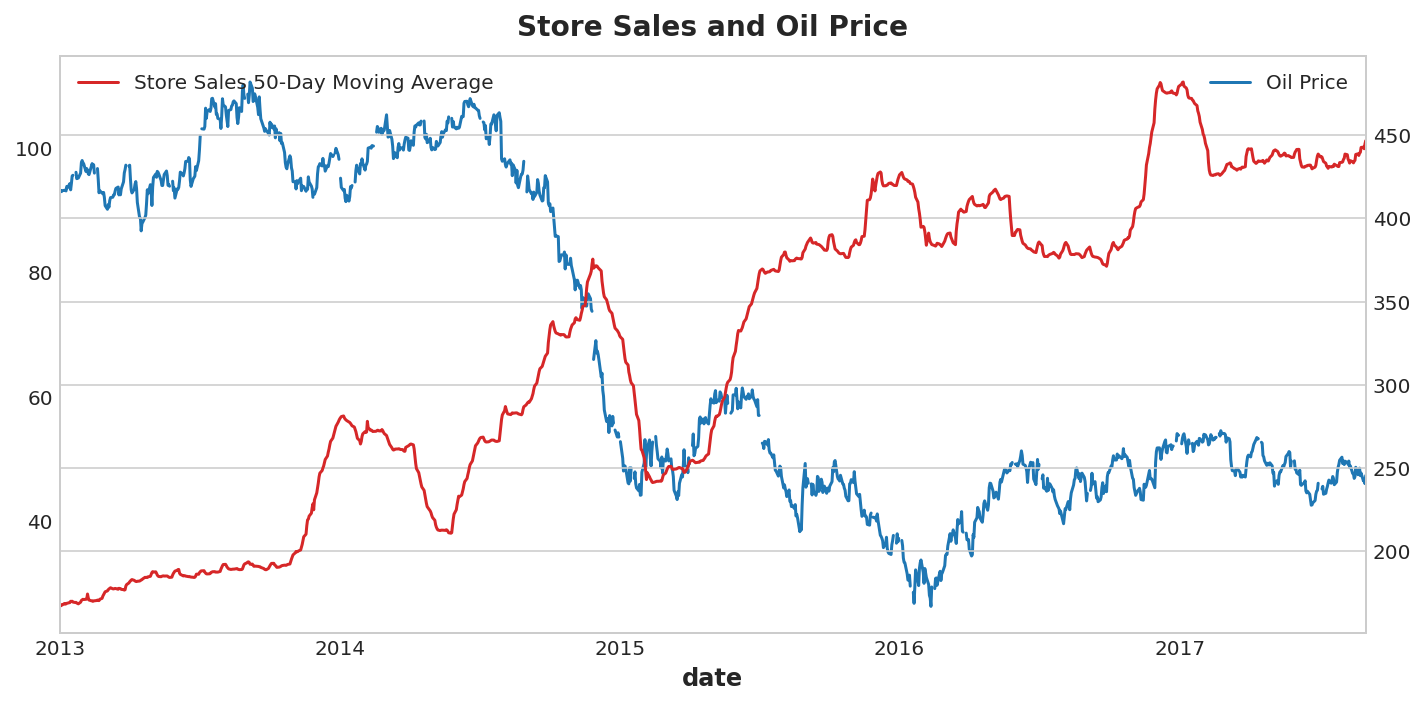

In [31]:
sales_ma = oil['average_store_sales'].rolling(
    window=50,
    center=True,
    min_periods=5,
).mean()   

fig, ax = plt.subplots(figsize=(10,5))
ax = oil['dcoilwtico'].plot(color='C0')
ax.legend(['Oil Price'])
# ax = oil['average_store_sales'].plot(color='C3', secondary_y=True)
ax = sales_ma.plot(color='C3', secondary_y=True)
ax.legend(['Store Sales 50-Day Moving Average'])
ax.set_title("Store Sales and Oil Price")

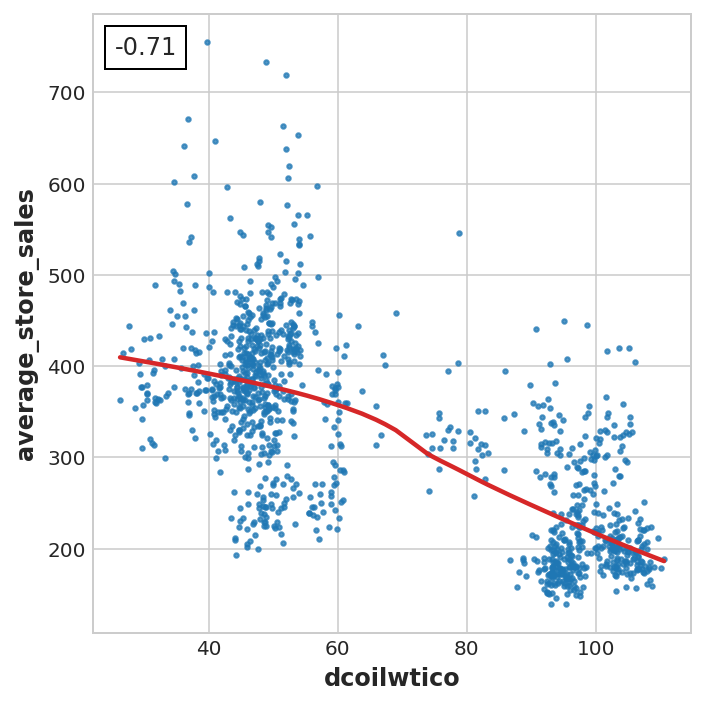

In [32]:
corrPlot(oil, x_param='dcoilwtico', y_param='average_store_sales')

In [24]:
HOLIDAYS_FP = os.path.join(IN_FP, 'holidays_events.csv')
holidays = pd.read_csv(HOLIDAYS_FP).set_index(['date']).sort_index()
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [25]:
TRANSACTIONS_FP = os.path.join(IN_FP, 'transactions.csv')
transactions = pd.read_csv(TRANSACTIONS_FP).set_index(['store_nbr','date']).sort_index()

transactions.head()

transactions
store_nbr date                    
1         2013-01-02          2111
          2013-01-03          1833
          2013-01-04          1863
          2013-01-05          1509
          2013-01-06           520

<AxesSubplot:xlabel='date'>

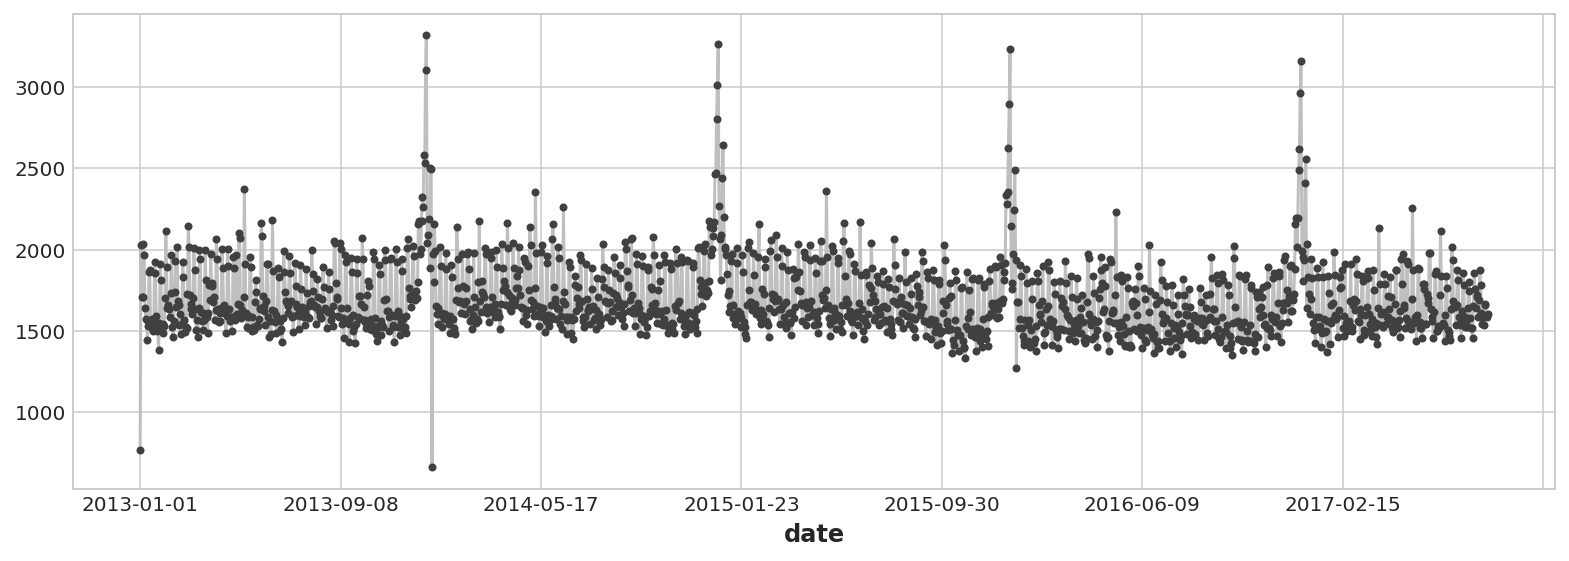

In [26]:
average_transactions = transactions.groupby('date').mean()['transactions']
average_transactions.plot(**plot_params)

In [27]:
# Check lags and autocorrelation

In [28]:
# Calculate residuals

In [29]:
# Fit residuals